In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import LineString
from datetime import datetime

%matplotlib inline

In [13]:
path = r'E:\Python\work\area chart\Unified Data.xlsx'

df = pd.read_excel(path)

In [14]:
#limit the data to just Scotland and two measures.

df = df[df['Location'] == 'NHS Scotland']
df = df[df['Measure Name'].isin(['Outpatient New', 'Outpatient Returns'])]

In [15]:
#calculate percent and absolute differences

group_lst = ['Location', 'Group', 'Speciality', 'Measure Name']

df['pct_diff'] = df.sort_values('Date').groupby(group_lst)['Measure Value'].pct_change()
df['abs_diff'] = df.sort_values('Date').groupby(group_lst)['Measure Value'].diff()

In [16]:
#test results
#df.groupby(['Location', 'Group', 'Speciality', 'Measure Name', 'Date']).min()

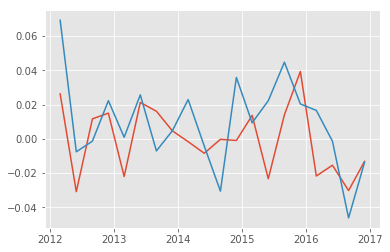

In [17]:
#create masks for filtering

mask_new = (df['Speciality'] == 'All Specialties') & (df['Measure Name'] == 'Outpatient New')
mask_return = (df['Speciality'] == 'All Specialties') & (df['Measure Name'] == 'Outpatient Returns')

#don't forget to sort!

x = np.array(sorted(df[mask_new].Date.values))

f = df[mask_new].sort_values(['Date']).pct_diff.values

g = df[mask_return].sort_values(['Date']).pct_diff.values

#plot

plt.style.use('ggplot')

plt.plot(x, f, '-')
plt.plot(x, g, '-')


In [18]:
df_grp = df.groupby(['Location', 'Group', 'Speciality','Date', 'Measure Name']).min()

In [19]:
df_grp.head(10)

Measure Value  \
Location     Group           Speciality      Date       Measure Name                        
NHS Scotland All Specialties All Specialties 2011-12-01 Outpatient New           359826.0   
                                                        Outpatient Returns       564882.0   
                                             2012-03-01 Outpatient New           369270.0   
                                                        Outpatient Returns       604011.0   
                                             2012-06-01 Outpatient New           357867.0   
                                                        Outpatient Returns       599442.0   
                                             2012-09-01 Outpatient New           362049.0   
                                                        Outpatient Returns       598640.0   
                                             2012-12-01 Outpatient New           367477.0   
                                                        Outpatient Returns       611972.0   

                                                                            pct_diff  \
Location     Group           Speciality      Date       Measure Name                   
NHS Scotland All Specialties All Specialties 2011-12-01 Outpatient New           NaN   
                                                        Outpatient Returns       NaN   
                                             2012-03-01 Outpatient New      0.026246   
                                                        Outpatient Returns  0.069269   
                                             2012-06-01 Outpatient New     -0.030880   
                                                        Outpatient Returns -0.007564   
                                             2012-09-01 Outpatient New      0.011686   
                                                        Outpatient Returns -0.001338   
                                             2012-12-01 Outpatient New      0.014992   
                                                        Outpatient Returns  0.022270   

                                                                            abs_diff  
Location     Group           Speciality      Date       Measure Name                  
NHS Scotland All Specialties All Specialties 2011-12-01 Outpatient New           NaN  
                                                        Outpatient Returns       NaN  
                                             2012-03-01 Outpatient New        9444.0  
                                                        Outpatient Returns   39129.0  
                                             2012-06-01 Outpatient New      -11403.0  
                                                        Outpatient Returns   -4569.0  
                                             2012-09-01 Outpatient New        4182.0  
                                                        Outpatient Returns    -802.0  
                                             2012-12-01 Outpatient New        5428.0  
                                                        Outpatient Returns   13332.0

In [64]:
#think of odd/even number of dates and how it affects the counters

#create polygon geometry for import to Tableau.

y_list = range(len(df_grp)-2) #subtract two to stop the counter.
x_list = range(len(df_grp.index.get_level_values('Date')))

#define polygon coordinate lists


x_temp = []
poly_y_temp = []
new_y_temp = []
return_y_temp = []

poly_y = []
poly_x = []
new_final = []
return_final = []


#define polygon parameters
poly_id = []
path_order = []
poly_colour =[]

polygon_id = 1

for i,j in zip(y_list[2::2], x_list[2::2]): #start from the 2nd position where dealing with change values.

    new_y1 = df_grp['pct_diff'].iloc[i]
    new_y2 = df_grp['pct_diff'].iloc[i+2]
    return_y1 = df_grp['pct_diff'].iloc[i+1]
    return_y2 = df_grp['pct_diff'].iloc[i+3]
    x1 = df_grp.index.get_level_values('Date')[j].timestamp()
    x2 = df_grp.index.get_level_values('Date')[j+2].timestamp()
    
    line1 = LineString([(x1,new_y1), (x2,new_y2)])
    line2 = LineString([(x1,return_y1), (x2,return_y2)])
    
    xcom = line1.intersection(line2)
    
    if xcom.is_empty:
        
        new_y_temp.extend([new_y1, new_y2])
        return_y_temp.extend([return_y1, return_y2])
        x_temp.extend([x1, x2])
    
    else:
        
        #create poly_x
        
        x_temp.append(xcom.x)
        x_temp = x_temp[:-1]+list(reversed(x_temp))
        poly_x.extend(x_temp)
        
        #write polygon parameters
        
        path_order.extend(list(range(1, len(x_temp)+1)))
        poly_id.extend([polygon_id]*(len(x_temp)))
        polygon_id += 1
        
        #flush x_temp
        
        x_temp = []
        
        #create new and return original lines in a matching order with poly_x
        
        new_y_temp.append(xcom.y)       
        new_final.extend(new_y_temp[:-1] + list(reversed(new_y_temp)))
        
        return_y_temp.append(xcom.y)
        return_final.extend(return_y_temp[:-1] + list(reversed(return_y_temp)))
        
        #create polygon y values
        
        poly_y_temp = new_y_temp[:-1] + list(reversed(return_y_temp))
        poly_y.extend(poly_y_temp)
                
        #add colour flag
        
        if new_y1 > return_y1:
            
            poly_colour.extend([1]*(len(poly_y_temp)))
            
        else:
            
            poly_colour.extend([0]*(len(poly_y_temp)))
                
        #flush all temps
        
        new_y_temp = []
        return_y_temp = []
        poly_y_temp = []
        
        #start new polygon
        
        x_temp.extend([xcom.x, x2])
        new_y_temp.extend([xcom.y, new_y2])
        return_y_temp.extend([xcom.y, return_y2])

print('done')

done


In [69]:
#fix the dates and export

new_dates = []

for d in poly_x:
    new_dates.append(datetime.fromtimestamp(d))

poly_df = pd.DataFrame({'date':new_dates, 'poly_y':poly_y, 'path_id':path_order,
                        'poly_id':poly_id, 'poly_colour': poly_colour,
                       'new_y':new_final, 'return_y': return_final})

poly_df.to_csv(r'E:\Python\work\area chart\poly_test_v2.csv', index=False)